# Description
In this playground competition, hosted in partnership with Google Cloud and Coursera, you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8, depending on the model used (see the starter code for an example of this approach in Kernels). Your challenge is to do better than this using Machine Learning techniques!

# 0. Starter


In [39]:
# Dependecies

import pandas as pd
import datetime 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt, rcParams

# Set a standard size and style
sns.set_style('whitegrid') 
rcParams['figure.figsize'] = (6, 4) # define plot sizes 

In [40]:
# We will take a sample of our dataset

url = 'https://raw.githubusercontent.com/krishnaik06/NYC-Taxi-Fares-Prediction/master/taxifare.csv'

data = pd.read_csv(url)

In [41]:
data.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [42]:
# Observe the size of the records 
data.shape
(120000, 8)

(120000, 8)

In [43]:
# My utc is 5  hours ahead NY and therefore I substract 5 hours 

df = data.sample(n = 5000) # I will generetate a random sample of 1000 records everytime 

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']) - datetime.timedelta(hours=5)

In [44]:
df.shape

(5000, 8)

In [45]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
34310,2010-04-23 09:45:48+00:00,13.3,1,-74.005015,40.751491,-73.973722,40.763886,2
88856,2010-04-11 14:05:01+00:00,7.7,0,-74.001410,40.730970,-73.771457,40.716523,3
23100,2010-04-23 23:30:06+00:00,3.3,0,-73.982182,40.778576,-73.982332,40.774121,1
66661,2010-04-13 08:47:07+00:00,8.5,0,-73.981904,40.766528,-74.003434,40.749138,2
6317,2010-04-23 03:41:00+00:00,5.3,0,-73.959575,40.774102,-73.970382,40.761723,1


# 1. Feature engineering

In [46]:
# Generat new date features
df['Month']=df['pickup_datetime'].dt.month
df['Day']=df['pickup_datetime'].dt.day
df['Hours']=df['pickup_datetime'].dt.hour
df['Minutes']=df['pickup_datetime'].dt.minute
df['Day of week']=df['pickup_datetime'].dt.dayofweek

In [47]:
# Create a column to specify morning and night 
df['morning_night']=np.where(df['Hours']<12,0,1)

# Drop pickup datetime
df.drop('pickup_datetime',axis=1,inplace=True)

In [48]:
# Check our df
df.head()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Month,Day,Hours,Minutes,Day of week,morning_night
34310,13.3,1,-74.005015,40.751491,-73.973722,40.763886,2,4,23,9,45,4,0
88856,7.7,0,-74.001410,40.730970,-73.771457,40.716523,3,4,11,14,5,6,1
23100,3.3,0,-73.982182,40.778576,-73.982332,40.774121,1,4,23,23,30,4,1
66661,8.5,0,-73.981904,40.766528,-74.003434,40.749138,2,4,13,8,47,1,0
6317,5.3,0,-73.959575,40.774102,-73.970382,40.761723,1,4,23,3,41,4,0


**Calculating Haversine distance** 

In [49]:
# Calculating Haversine distance

from sklearn.metrics.pairwise import haversine_distances
from math import radians
newdelhi = [28.6139, 77.2090]
bangalore = [12.9716, 77.5946]

newdelhi_in_radians = [radians(_) for _ in newdelhi]
bangalore_in_radians = [radians(_) for _ in bangalore]

result = haversine_distances([newdelhi_in_radians, bangalore_in_radians])
result*6371

array([[   0.       , 1739.8021019],
       [1739.8021019,    0.       ]])

In [50]:
np.radians(df['dropoff_latitude']-df["pickup_latitude"])

34310    0.000216
88856   -0.000252
23100   -0.000078
66661   -0.000304
6317    -0.000216
           ...   
9115     0.000113
1041    -0.000889
37910   -0.000302
77300   -0.000330
18482    0.000721
Length: 5000, dtype: float64

In [51]:
# Create a function to calculate haversine distance 
def haversine(df):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lat1= np.radians(df["pickup_latitude"])
    lat2 = np.radians(df["dropoff_latitude"])
    #### Based on the formula  x1=drop_lat,x2=dropoff_long 
    dlat = np.radians(df['dropoff_latitude']-df["pickup_latitude"])
    dlong = np.radians(df["dropoff_longitude"]-df["pickup_longitude"])
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong/2)**2

    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [52]:
df['total_distance']= haversine(df)

In [53]:
df.head()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Month,Day,Hours,Minutes,Day of week,morning_night,total_distance
34310,13.3,1,-74.005015,40.751491,-73.973722,40.763886,2,4,23,9,45,4,0,2.974341
88856,7.7,0,-74.001410,40.730970,-73.771457,40.716523,3,4,11,14,5,6,1,19.444751
23100,3.3,0,-73.982182,40.778576,-73.982332,40.774121,1,4,23,23,30,4,1,0.495534
66661,8.5,0,-73.981904,40.766528,-74.003434,40.749138,2,4,13,8,47,1,0,2.650962
6317,5.3,0,-73.959575,40.774102,-73.970382,40.761723,1,4,23,3,41,4,0,1.650151


We apply PCA to transform longitude and latitude coordinates. In this case it is not about dimension reduction since he transformed 2D-> 2D. The rotation could help for decision tree splits, and it did actually.

In [54]:
coords = np.vstack((df[['pickup_latitude', 'pickup_longitude']].values,
                    df[['dropoff_latitude', 'dropoff_longitude']].values
                   ))

In [55]:
coords 

array([[ 40.751491, -74.005015],
       [ 40.73097 , -74.00141 ],
       [ 40.778576, -73.982182],
       ...,
       [ 40.761937, -73.963308],
       [ 40.705221, -73.942839],
       [ 40.750611, -73.973542]])

In [56]:
# Use PCA to transform pickup and dropoff

from sklearn.decomposition import PCA
 
pca = PCA().fit(coords)
df['pickup_pca0'] = pca.transform(df[['pickup_latitude', 'pickup_longitude']])[:, 0]
df['pickup_pca1'] = pca.transform(df[['pickup_latitude', 'pickup_longitude']])[:, 1]
df['dropoff_pca0'] = pca.transform(df[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
df['dropoff_pca1'] = pca.transform(df[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [57]:
df.head()

,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Month,Day,Hours,Minutes,Day of week,morning_night,total_distance,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
34310,13.3,1,-74.005015,40.751491,-73.973722,40.763886,2,4,23,9,45,4,0,2.974341,0.026280,-0.012184,-0.007339,-0.010547
88856,7.7,0,-74.001410,40.730970,-73.771457,40.716523,3,4,11,14,5,6,1,19.444751,0.031472,0.007994,-0.171984,0.116127
23100,3.3,0,-73.982182,40.778576,-73.982332,40.774121,1,4,23,23,30,4,1,0.495534,-0.005701,-0.027420,-0.003725,-0.023425
66661,8.5,0,-73.981904,40.766528,-74.003434,40.749138,2,4,13,8,47,1,0,2.650962,-0.000978,-0.016333,0.025812,-0.009388
6317,5.3,0,-73.959575,40.774102,-73.970382,40.761723,1,4,23,3,41,4,0,1.650151,-0.024442,-0.014008,-0.009487,-0.007198


In [58]:
df.drop(["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"],axis=1,inplace = True)

Here is our final result:

In [59]:
df.head()

,fare_amount,fare_class,passenger_count,Month,Day,Hours,Minutes,Day of week,morning_night,total_distance,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
34310,13.3,1,2,4,23,9,45,4,0,2.974341,0.026280,-0.012184,-0.007339,-0.010547
88856,7.7,0,3,4,11,14,5,6,1,19.444751,0.031472,0.007994,-0.171984,0.116127
23100,3.3,0,1,4,23,23,30,4,1,0.495534,-0.005701,-0.027420,-0.003725,-0.023425
66661,8.5,0,2,4,13,8,47,1,0,2.650962,-0.000978,-0.016333,0.025812,-0.009388
6317,5.3,0,1,4,23,3,41,4,0,1.650151,-0.024442,-0.014008,-0.009487,-0.007198


In [60]:
# Generate the final data csv 
df.to_csv('final_data.csv')

### Findings: 
- To use numerical transformations such as PCA could be beneficial
- Are there other variations of distance calculations

# 2. EDA

In [ ]:
# There are no missing values

df.isnull().sum()

fare_amount        0
fare_class         0
passenger_count    0
Month              0
Day                0
Hours              0
Minutes            0
Day of week        0
morning_night      0
total_distance     0
pickup_pca0        0
pickup_pca1        0
dropoff_pca0       0
dropoff_pca1       0
dtype: int64

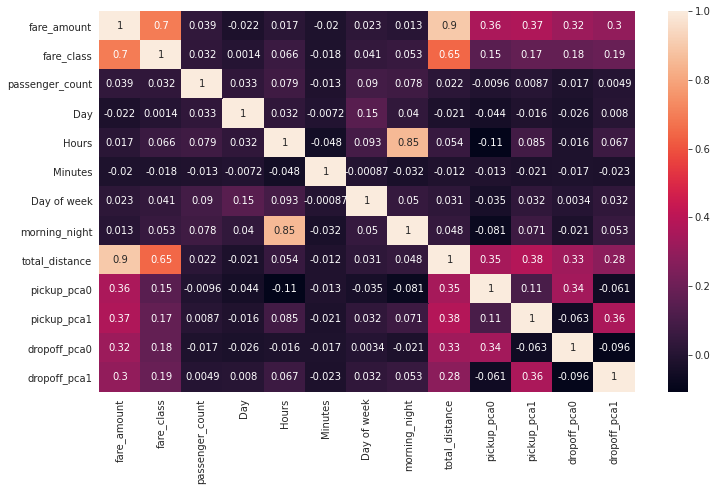

In [ ]:
plt.figure(figsize=(12,7))
sns.heatmap(df.drop('Month',axis= 1).corr(), annot=True)

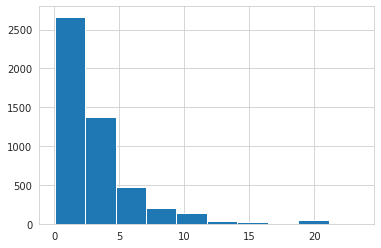

In [ ]:
# Checking the distribution 

df.total_distance.hist()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


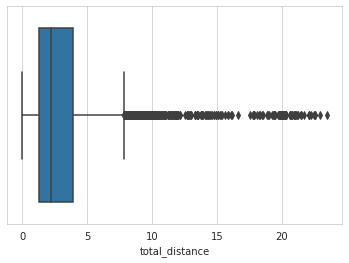

In [ ]:
sns.boxplot(df.total_distance ) 

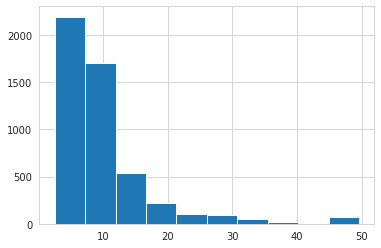

In [ ]:
df.fare_amount.hist()

In [ ]:
# Checking the outliers for non gaussian distributions
def identify_outliers(data = df, column = 'total_distance'):
    from numpy import percentile
    # To indentify outliers in a Non Gaussian distribution we use 25 and 75 percentiles 
    q25, q75 = percentile(data[column], 25) , percentile(df.total_distance, 75) 
    iqr = q75 - q25
    # calculate the outlier cutoff - Lower and upper
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    #print(f'Upper {upper}, Lower {lower}')
    # identify outliers
    outliers = [x for x in data[column] if x < lower or x > upper]
    output = ('Identified outliers: %d' % len(outliers))
    return output

In [ ]:
cols = ['fare_amount' , 'total_distance' ]

In [ ]:
for col in cols:
    print(col,identify_outliers(column = col)) 

fare_amount Identified outliers: 5000
total_distance Identified outliers: 395


In [ ]:
df.head()

,fare_amount,fare_class,passenger_count,Month,Day,Hours,Minutes,Day of week,morning_night,total_distance,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
0,6.5,0,1,4,19,3,17,0,0,2.126312,-0.023334,0.013860,-0.002526,0.006523
1,6.9,0,1,4,17,10,43,5,0,1.392307,-0.017643,0.005282,-0.001564,0.007563
2,10.1,1,2,4,17,6,23,5,0,3.326763,-0.017715,-0.006036,0.019514,-0.008114
3,8.9,0,1,4,11,16,25,6,1,1.864129,-0.012411,-0.009700,0.002710,0.004820
4,19.7,1,1,4,16,21,19,4,1,7.231321,-0.020732,0.010909,0.061941,0.032656


In [ ]:
df['passenger_count'].describe()

count    5000.000000
mean        1.348400
std         0.762321
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         5.000000
Name: passenger_count, dtype: float64

In [ ]:
# There are no outliers in the column passenger count

print(identify_outliers(data = data , column = 'pickup_latitude')) 

Identified outliers: 120000


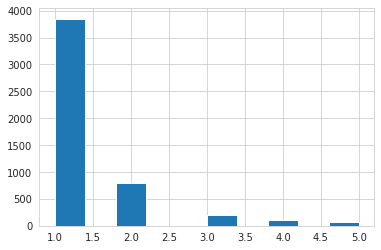

In [ ]:
df['passenger_count'].hist()

**Does the number of passengers affect the fare?**

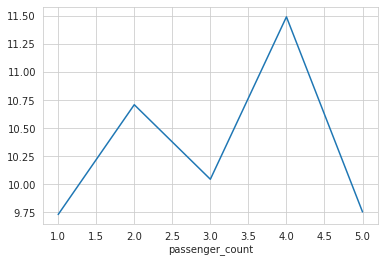

In [ ]:
# 2 passengers 
df.groupby('passenger_count')['fare_amount'].mean().plot(kind='line')

# The average fare amount is a little bit higher for 2 passengers 

- **Does the date and time of pickup affect the fare?**
- **Does the day of the week affect the fare?**
- **Does the distance travelled affect the fare?**

In [ ]:
def target_col(data = df , group = 'passenger_count', target = 'fare_amount' , kind = 'bar' ):
    var = data.groupby(group)[target].mean().sort_values(ascending = False)
    return var.plot(kind = kind)

passenger_count AxesSubplot(0.125,0.125;0.775x0.755)


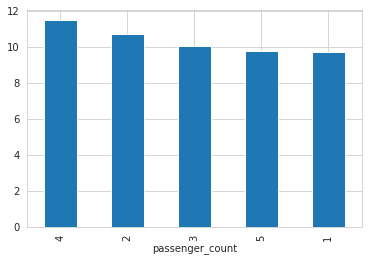

Hours AxesSubplot(0.125,0.125;0.775x0.755)


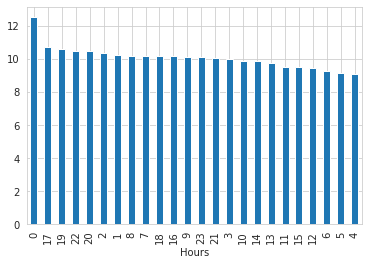

Day AxesSubplot(0.125,0.125;0.775x0.755)


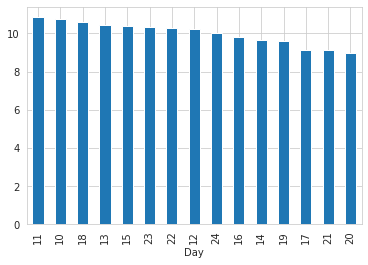

morning_night AxesSubplot(0.125,0.125;0.775x0.755)


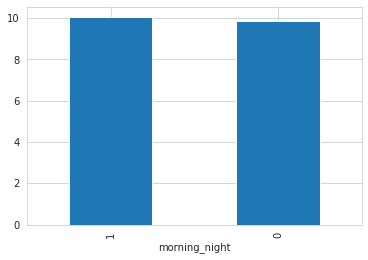

In [ ]:
cols = ['passenger_count','Hours','Day' , 'morning_night' ]
for group in cols:
    print(group,target_col(group = group , kind='bar' ))
    plt.show()

In [ ]:
# There is clear sign that hours si a feature with high impact in the fare amount

In [ ]:
# Observe that there is only one month
df.Month.nunique()

1

**Does the distance travelled affect the fare?**

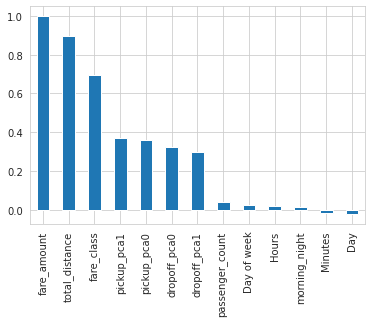

In [ ]:
df.drop('Month',axis= 1).corr()['fare_amount'].sort_values(ascending=False).plot(kind='bar')

# 3. Feature Selection - Base parameters
I will use xgboost and feature importance to find the best features

In [26]:
df.head()

,fare_amount,fare_class,passenger_count,Month,Day,Hours,Minutes,Day of week,morning_night,total_distance,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
33161,7.3,0,1,4,24,18,27,5,1,3.839270,0.017481,0.010159,0.048176,0.031214
114630,5.3,0,1,4,23,14,10,4,1,2.028187,0.008550,0.004674,0.027695,0.012636
62397,4.1,0,5,4,22,18,51,3,1,1.283657,-0.042958,-0.022403,-0.031684,-0.016375
94302,4.5,0,1,4,23,7,54,4,0,0.903577,-0.022546,0.013926,-0.016062,0.006418
21674,9.7,0,1,4,23,5,19,4,0,3.614533,0.034336,0.022910,0.000892,0.007875


In [27]:
############
# XGBOOST method 1
############
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.feature_selection import SelectFromModel

seed = 0 
X = df.drop('fare_amount',axis=1 )
y = df.fare_amount

In [28]:
X.head()

,fare_class,passenger_count,Month,Day,Hours,Minutes,Day of week,morning_night,total_distance,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
33161,0,1,4,24,18,27,5,1,3.839270,0.017481,0.010159,0.048176,0.031214
114630,0,1,4,23,14,10,4,1,2.028187,0.008550,0.004674,0.027695,0.012636
62397,0,5,4,22,18,51,3,1,1.283657,-0.042958,-0.022403,-0.031684,-0.016375
94302,0,1,4,23,7,54,4,0,0.903577,-0.022546,0.013926,-0.016062,0.006418
21674,0,1,4,23,5,19,4,0,3.614533,0.034336,0.022910,0.000892,0.007875


In [29]:
# Train test split 
X_train, X_valid , y_train , y_valid = train_test_split(X,y , test_size =0.3,random_state = 0)

In [30]:
print(X_train.shape)
print(X_valid.shape)

(21000, 13)
(9000, 13)


In [31]:
model = XGBRegressor()
model.fit(X_train,y_train)
pred = model.predict(X_valid)
mse_error = mse(y_valid,pred)

[09:32:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [32]:
mse_error

6.009738355119362

In the example below we first train and then evaluate an XGBoost model on the entire training dataset and test datasets respectively.

In [33]:
thresholds = np.sort(model.feature_importances_)

for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBRegressor()
	selection_model.fit(select_X_train, y_train)
	
    # eval model
	select_X_test = selection.transform(X_valid)
	predictions = selection_model.predict(select_X_test)
	error = mse(y_valid, predictions)
	print("Thresh=%.3f, n=%d, MSE: %.2f" % (thresh, select_X_train.shape[1], error))

[09:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.000, n=13, MSE: 6.01
[09:32:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.000, n=13, MSE: 6.01
[09:32:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.002, n=11, MSE: 6.01
[09:32:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.004, n=10, MSE: 6.02
[09:32:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.005, n=9, MSE: 6.04
[09:32:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Thresh=0.006, n=8, MSE: 6.06
[09:32:15] WARNING: /workspace/src/objective/regression_obj.

In [34]:
# Here we can see the highest error is with 5 features

[09:32:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


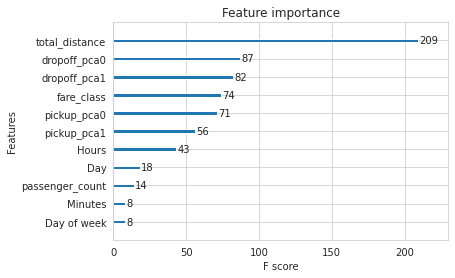

In [35]:
############
# XGBOOST method 2
############

# plot feature importance
from xgboost import plot_importance

# fit model no training data
model.fit(X, y)
# plot feature importance
plot_importance(model)
plt.show()

In [36]:
############
# Extra Tree Regressor 
############
from sklearn.ensemble import ExtraTreesRegressor
model_tree = ExtraTreesRegressor()
model_tree.fit(X,y)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

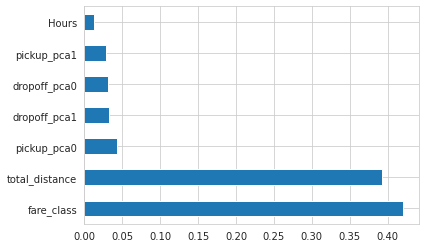

In [37]:
f_importances = pd.Series(model_tree.feature_importances_,index = X.columns )
f_importances.nlargest(7).plot(kind='barh')

### Findings 
- The total distance and fare class are the most important features based on Extra tree regressor and Xgboost feature importances
- We can see that the level of importance is diffrent based on the method we use 

# 4. Modelling
BEST SCORE: 6.344787 MSE with xgboost
30 000 records. MSE: 5.497501 using RF


### 4.1 Evaluate various models without scaling 

In [114]:
X.head()

,fare_class,passenger_count,Month,Day,Hours,Minutes,Day of week,morning_night,total_distance,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
47234,0,5,4,21,5,22,2,0,1.580669,-0.031560,0.000093,-0.014087,-0.001821
73872,1,2,4,22,7,45,3,0,8.832125,0.002299,-0.004699,0.104609,0.012426
17371,0,1,4,20,1,42,1,0,2.726594,-0.005229,-0.028554,-0.001314,-0.003078
54766,0,3,4,24,13,9,5,1,1.504852,0.045539,0.023780,0.061642,0.020718
2512,1,1,4,23,2,28,4,0,3.505765,0.035672,-0.023627,-0.004213,-0.023028


In [115]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR 
from sklearn.model_selection import KFold, cross_val_score

seed = 0  # Use the same seed through the exercises  
models = []
results = [] 
names = []

models.append(('XGB', XGBRegressor(silent=True , random_state= seed )))
models.append(('RF', RandomForestRegressor(random_state= seed)))
models.append(('LSVR', LinearSVR(random_state= seed)))

In [116]:
# Result 1 - No scaling used 
for model_name,model in models: 
    print(f'Now training... {model_name}')
    kfold = KFold(n_splits = 5, random_state = seed , shuffle=True ) # change the seed
    print(f'Calculating cv_results...')
    cv_results = -1 * cross_val_score(model,X,y, cv = kfold,scoring='neg_mean_squared_error')
    print(f'Appending to results...')
    results.append(cv_results)
    names.append(model_name)
    msg = "%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std())
    print(f'Result {msg}')

Now training... XGB
Calculating cv_results...
Appending to results...
Result XGB: 6.347467 (1.222547)
Now training... RF
Calculating cv_results...
Appending to results...
Result RF: 6.451535 (1.206152)
Now training... LSVR
Calculating cv_results...


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Appending to results...
Result LSVR: 10.101524 (1.834429)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


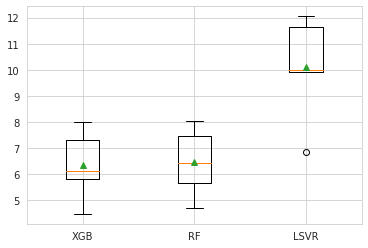

In [117]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [118]:
results

[array([7.99015222, 7.32904022, 6.11064478, 4.48099323, 5.82650623]),
 array([8.03408096, 7.46593102, 6.41516459, 4.69116043, 5.65133569]),
 array([11.66065208, 12.05407222,  9.93469767,  6.85422189, 10.003978  ])]

### 4.2 Evaluate various models with scaling 

In [164]:
# Scale X and y to make LSVR converge 

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

seed = 0  # Use the same seed through the exercises  
models2 = []
results2 = [] 
names2 = []

models2.append(('XGB', XGBRegressor(silent=True, random_state = seed )))
models2.append(('RF', RandomForestRegressor( random_state = seed )))
models2.append(('LSVR', LinearSVR(random_state = seed  )))

In [165]:
# Result 2 - Scaling - Here I pass the scaled version 
for model_name,model in models2: 
    print(f'Now training... {model_name}')
    kfold = KFold(n_splits = 5, random_state = seed , shuffle=True ) # change the seed
    print(f'Calculating cv_results...')
    
    # Observe that here I will use the scaled version of X 
    cv_results = -1 * cross_val_score(model, X_scaled,y, cv = kfold,scoring='neg_mean_squared_error')
    print(f'Appending to results...')
    results2.append(cv_results)
    names2.append(model_name)
    msg = "%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std())
    
    print(f'Result {msg}')

Now training... XGB
Calculating cv_results...
Appending to results...
Result XGB: 5.925881 (0.233370)
Now training... RF
Calculating cv_results...
Appending to results...
Result RF: 5.497501 (0.253806)
Now training... LSVR
Calculating cv_results...
Appending to results...
Result LSVR: 9.592559 (0.459155)


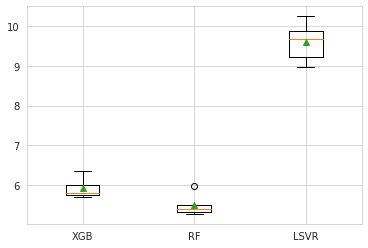

In [166]:
plt.boxplot(results2, labels=names2, showmeans=True)
plt.show()

# We see the same results but LSVR needed to have scaled data as inputs

In [167]:
results2

[array([6.35018712, 5.71194863, 5.81371977, 5.75614862, 5.99740191]),
 array([5.98207397, 5.28215849, 5.31811681, 5.40415293, 5.5010019 ]),
 array([ 9.87786976,  8.95951985,  9.21590424, 10.24435424,  9.66514699])]

## Findings - Best results:
- 6.655964 and 6.656847  MSE with xgboost
- We can see that XGB and RF gave us similar mse 
- It could be beneficial to scale the data first
- The number of records will affect the final output


# 5. Hyper parameter tunning 
Here we will comprare randomized grid search and gaussian methods to be able to find the best parameters. 

BEST SCORE: XGBOOST: 6.668229



## 5.1 Random Forest and XGBoost tuning


**Random Forest**

In [141]:
# Random Forest - Select the best n_estimators: 

def get_score(n_estimators , cv = 5 ): 
    print(f'Now training: {n_estimators }')
    model = RandomForestRegressor(n_estimators = n_estimators , random_state = seed)
    print(f'Now obtaining the score for: {n_estimators }')
    score = -1 * cross_val_score(model, X, y, cv = cv , scoring = 'neg_mean_squared_error' )
    
    return score.mean()

In [142]:
results = {}
n_estimators = [50, 100, 150,200,250,300,350] 

for i in n_estimators:
  results[i] = get_score(i)
    

# NOTE: Re run the loop with mean squared error . This is taking too long 

Now training: 50
Now obtaining the score for: 50
Now training: 100
Now obtaining the score for: 100
Now training: 150
Now obtaining the score for: 150
Now training: 200
Now obtaining the score for: 200
Now training: 250
Now obtaining the score for: 250
Now training: 300
Now obtaining the score for: 300
Now training: 350
Now obtaining the score for: 350


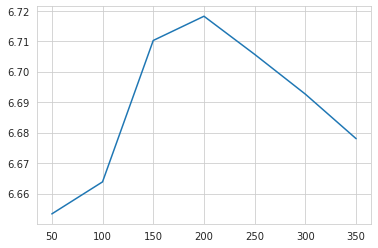

In [143]:
plt.plot(list(results.keys()) ,list(results.values()))

Depending on the sample from the original df the how the mse varies depends

**XGBOOST** 

In [144]:
# STEP 1 Tune max_depth and min_child_weight
from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':[i for i in range(3,28,2)],
 'min_child_weight':[i for i in range(1,10,2)]
}


xgb_model = XGBRegressor(silent = True)
gsearch1 = GridSearchCV(estimator = xgb_model, param_grid  = param_test1 , cv = 5, scoring='neg_mean_squared_error')

gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=True,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                       25, 27],
     

In [145]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 1}, -6.466229889419196)

In [146]:
# STEP 2 Tune gamma 

param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gsearch2 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)

gsearch2.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[15:23:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=4,
                                    min_child_weight=6, missing=None,
                                    n_estimators=140, n_jobs=1, nthread=4,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=27, silent=None,
                                    subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
     

In [147]:
gsearch2.best_params_, gsearch2.best_score_

({'gamma': 0.4}, -6.315368104290968)

### Random Forest vs XGBoost Results - Using tuning parameters

In [150]:
models = [] 

models.append(('Random Forest',RandomForestRegressor(n_estimators= 50) ))
models.append(('XGBOOST', XGBRegressor(max_depth= 3 , min_child_weight= 1 , gamma= 0.4 ) ) )


In [151]:
results_tuning = []
names =  []
for model_name,model in models: 
    print(f'Now training... {model_name}')
    kfold = KFold(n_splits = 5, random_state = seed , shuffle=True ) # change the seed
    print(f'Calculating cv_results...')
    cv_results = -1 * cross_val_score(model,X,y, cv = kfold,scoring='neg_mean_squared_error')
    print(f'Appending to results...')
    results_tuning .append(cv_results)
    names.append(model_name)
    msg = "%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std())
    print(f'Result {msg}')

Now training... Random Forest
Calculating cv_results...
Appending to results...
Result Random Forest: 6.795584 (1.615105)
Now training... XGBOOST
Calculating cv_results...
[15:25:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:25:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:25:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:25:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:25:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Appending to results...
Result XGBOOST: 6.668229 (1.626200)


#### Findings: 
- Result Random Forest: 6.795584 
- Result XGBOOST: 6.668229 (1.626200)

## 5.2 Randomized Grid search - XGBOOST 
- https://medium.com/@hiepnguyen034/improving-neural-networks-performance-with-bayesian-optimization-efbaa801ad26

In [61]:
seed = 0 
X = df.drop('fare_amount',axis=1 )
y = df.fare_amount

# Standard params
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state = seed  , silent=True)

params = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10)}

random_grid =  RandomizedSearchCV(xgb ,param_distributions = params ,scoring ='neg_mean_squared_error', n_iter = 25)
random_grid.fit(X,y)

y_rs = np.maximum.accumulate(random_grid.cv_results_['mean_test_score'])

In [ ]:
y_rs

## 5.3  Bayesian Optimization - XGBOOST 

In [62]:
! pip install GPyOpt

     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 1.0MB 5.8MB/s 
     |████████████████████████████████| 71kB 6.9MB/s 
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-cp36-none-any.whl size=83622 sha256=e01c6d5eab4c4ace86f354648b7e600e405f435e2cd06244ed1bf99f8fd1984f
  Stored in directory: /root/.cache/pip/wheels/b2/00/69/cfa967a125cf25e66f644be6193ad6f0edf231147879ad714f
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633939 sha256=d4640b53ea99d514bd25c96ce37ec0088c812f608baa8f4133f54148dd596d16
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102551 sha256=10feb70b4e8f2bd679ca880f5b8a5a878d16624907d47ed2f4ba1bc4caa94398
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPyOpt GPy paramz


In [63]:

from GPyOpt.methods import BayesianOptimization
# 1 params 
bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)},
        {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}]

# 2 Obtain the cv score- Optimization objective 

def cv_score(parameters):
    parameters = parameters[0]
    xgb = XGBRegressor(learning_rate=parameters[0],
                              gamma=int(parameters[1]),
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              min_child_weight = parameters[4], silent= True , random_state = seed )# Set silent to True to remove the warnings  
    score = cross_val_score(
               xgb , 
                X, y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

# 3 Obtain the cv score

optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True)

# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter = 20)

In [64]:
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

In [65]:
print(f'Random search neg. MSE = {y_rs[-1]:.2f}')
print(f'Bayesian optimization neg. MSE = {y_bo[-1]:.2f}')

Random search neg. MSE = -6.95
Bayesian optimization neg. MSE = -8.12


Observe how the bayesian otimization  improves

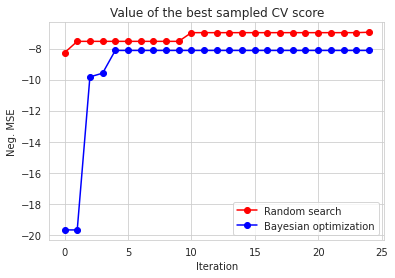

In [66]:
plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
#plt.ylim(-5000, -3000)
plt.title('Value of the best sampled CV score');
plt.legend();

It might happen that one method outperforms another (here https://arimo.com/data-science/2016/bayesian-optimization-hyperparameter-tuning/ people compare Bayesian hyperparameter optimization and achieve a better result on the San Francisco crime kaggle challenge than with random search), however I doubt that there is a general rule for that. You can see a nice gif here (http://blog.revolutionanalytics.com/2016/06/bayesian-optimization-of-machine-learning-models.html) where people show the 'path' that Bayesian optimization takes in the landscape of hyperparameters, in particular, it does not seem as if it outperforms random search in general.

# 6. Artificial Neural networks
Best score: 7.335333663634385 using TPOP REGRESSOR  

Score with 30 000 records MSE 5.9721446972614665


In [168]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Dropout

In [169]:
# train , valid splits 
X_train , X_valid , y_test , y_valid= train_test_split(X,y, test_size = 0.3, random_state= seed )

In [170]:
model = Sequential()
# We will use normal as initialization technique 
model.add(Dense(128, kernel_initializer = 'normal', input_dim = X_train.shape[1] , activation = 'relu' )) # I will use relu activation function for all the nodes

# Hidden layers
model.add(Dense(256, kernel_initializer = 'normal',activation = 'relu' )) # we could also use leaky relu but we would need to tune the model
model.add(Dense(256, kernel_initializer = 'normal',activation = 'relu' )) 
model.add(Dense(256, kernel_initializer = 'normal',activation = 'relu' )) 

# Output Layer 
model.add(Dense(1, kernel_initializer = 'normal',activation = 'linear' )) # we use linear fo regression problems  

# Compile
model.compile(loss = 'mean_squared_error' , optimizer ='adam' , metrics=['mean_squared_error'] )

model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               1792      
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 166,657
Trainable params: 166,657
Non-trainable params: 0
_________________________________________________________________


In [171]:
model.fit(X_valid, y_valid,  validation_split =0.33 , batch_size = 10 , epochs = 40 )

Epoch 1/40
603/603 [==============================] - 2s 3ms/step - loss: 16.5669 - mean_squared_error: 16.5669 - val_loss: 8.9233 - val_mean_squared_error: 8.9233
Epoch 2/40
603/603 [==============================] - 2s 3ms/step - loss: 11.1006 - mean_squared_error: 11.1006 - val_loss: 9.2116 - val_mean_squared_error: 9.2116
Epoch 3/40
603/603 [==============================] - 2s 3ms/step - loss: 10.8755 - mean_squared_error: 10.8755 - val_loss: 9.8784 - val_mean_squared_error: 9.8784
Epoch 4/40
603/603 [==============================] - 2s 3ms/step - loss: 10.4840 - mean_squared_error: 10.4840 - val_loss: 10.1330 - val_mean_squared_error: 10.1330
Epoch 5/40
603/603 [==============================] - 2s 3ms/step - loss: 10.4098 - mean_squared_error: 10.4098 - val_loss: 10.0541 - val_mean_squared_error: 10.0541
Epoch 6/40
603/603 [==============================] - 2s 3ms/step - loss: 10.2768 - mean_squared_error: 10.2768 - val_loss: 9.6801 - val_mean_squared_error: 9.6801
Epoch 7/40
6

## 6.1 Model evaluation 


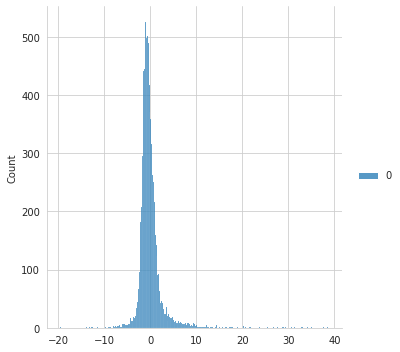

In [172]:
import seaborn as sns

prediction = model.predict(X_valid)

print(sns.displot(y_valid.values.reshape(-1,1) - prediction ) )

In [173]:
from sklearn.metrics import mean_squared_error , mean_absolute_error 

print(f' Mean squared error {mean_squared_error(y_valid, prediction)}' )
print(f' Mean absolute error {mean_absolute_error(y_valid, prediction)}' )

# 20 epochs 

#Mean squared error 9.683787394397097
#Mean absolute error 1.5232585242843628

# 40 epochs 
#Mean squared error 9.069073109835461

# 40 epochs /30000 records 
# Mean squared error 7.05731604455969

 Mean squared error 7.05731604455969
 Mean absolute error 1.4871519275781844


Lets try to find the best parameters

## 6.2 Hyperparam tuning


In [37]:
from keras.wrappers.scikit_learn import KerasRegressor

# create the model 
def create_model():
  """
  NN architecture 
  """
  model = Sequential()
  model.add(Dense(128, kernel_initializer = 'normal', input_dim = X_train.shape[1] , activation = 'relu' )) # I will use relu activation function for all the nodes
  # Hidden layers
  model.add(Dense(256, kernel_initializer = 'normal',activation = 'relu' )) # we could also use leaky relu but we would need to tune the model
  model.add(Dense(256, kernel_initializer = 'normal',activation = 'relu' )) 
  model.add(Dense(256, kernel_initializer = 'normal',activation = 'relu' )) 
  # Output Layer 
  model.add(Dense(1, kernel_initializer = 'normal',activation = 'linear' )) # we use linear fo regression problems  
  # Compile
  model.compile(loss = 'mean_squared_error' , optimizer ='adam' , metrics=['mean_squared_error'] )
  return model 

# put on kerasregressor 
model = KerasRegressor(build_fn = create_model, verbose = 0  )



In [173]:
# This is taking very long consider chaing to TPU 

# define batch size and epcohs 
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X.values, y.values )


In [174]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Test the model with tuned params 

Best: -7.375117 using {'batch_size': 20, 'epochs': 50}
-8.335835 (1.313411) with: {'batch_size': 10, 'epochs': 10}
-7.708182 (2.045469) with: {'batch_size': 10, 'epochs': 50}
-7.840468 (2.415734) with: {'batch_size': 10, 'epochs': 100}
-8.508542 (1.329013) with: {'batch_size': 20, 'epochs': 10}
-7.375117 (2.096263) with: {'batch_size': 20, 'epochs': 50}
-7.514588 (2.184784) with: {'batch_size': 20, 'epochs': 100}
-9.011900 (1.283214) with: {'batch_size': 40, 'epochs': 10}
-7.503144 (1.434223) with: {'batch_size': 40, 'epochs': 50}
-7.650668 (1.588610) with: {'batch_size': 40, 'epochs': 100}
-8.581600 (1.394508) with: {'batch_size': 60, 'epochs': 10}
-7.385262 (1.624646) with: {'batch_size': 60, 'epochs': 50}
-7.605318 (2.058633) with: {'batch_size': 60, 'epochs': 100}
-8.498437 (1.094798) with: {'batch_size': 80, 'epochs': 10}
-7.574903 (1.565402) with: {'batch_size': 80, 'epochs': 50}
-7.849353 (2.162563) with: {'batch_size': 80, 'epochs': 100}
-8.357436 (1.592923) with: {'batch_size'

### Findings
- We could improve the score but xgboost model is still the best score

## 6.3 TPOT regressor 
-7.45191217933125  
-5.9721446972614665 30 000 records
TPOT is an open-source library for performing AutoML in Python. It makes use *of the popular Scikit-Learn machine learning library for data transforms and machine learning algorithms and uses a Genetic Programming stochastic global search procedure to efficiently discover a top-performing model pipeline for a given dataset.*

More Info: https://machinelearningmastery.com/tpot-for-automated-machine-learning-in-python/ 


We will use TPOT regressor for genetical algorithms. We will create a n number of iterations 


In [174]:
! pip install tpot

In [175]:
from tpot import TPOTRegressor 

In [176]:
# Fit Tpot on X and y 
# regressor = TPOTRegressor()
# regressor.fit(X,y)

In [177]:
# Crete a tpot var
# Generation1 : MSE : 8.200143655408343

tpot = TPOTRegressor(generations = 5 , population_size = 10 , verbosity = 2, random_state = seed ) # Observe that if we increase our generations we could improve our results 
tpot.fit(X_train, y_train)
print(tpot.score(X_valid,y_valid) )

# Export the file 
tpot.export('tpot_pipeline.py')



Generation 1 - Current best internal CV score: -5.353936261689637

Generation 2 - Current best internal CV score: -5.353936261689637

Generation 3 - Current best internal CV score: -5.353936261689637

Generation 4 - Current best internal CV score: -5.348461704935954

Generation 5 - Current best internal CV score: -5.348461704935954

Best pipeline: XGBRegressor(AdaBoostRegressor(input_matrix, learning_rate=0.01, loss=square, n_estimators=100), learning_rate=0.1, max_depth=7, min_child_weight=7, n_estimators=100, nthread=1, objective=reg:squarederror, subsample=0.6500000000000001)
-6.0161305759919435


In [178]:
# Here is the output:

from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('final_data.csv')
features = tpot_data.drop('fare_amount', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['fare_amount'], random_state=0)


In [179]:
# Average CV score on the training set was: -5.348461704935954
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=AdaBoostRegressor(learning_rate=0.01, loss="square", n_estimators=100)),
    XGBRegressor(learning_rate=0.1, max_depth=7, min_child_weight=7, n_estimators=100, nthread=1, objective="reg:squarederror", subsample=0.6500000000000001)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 0)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [180]:
results

array([ 7.3963337, 13.874862 ,  9.065026 , ...,  4.3731413,  7.663726 ,
       12.337973 ], dtype=float32)

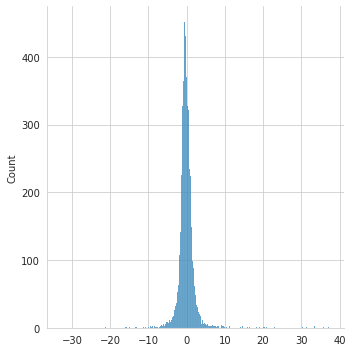

In [181]:
sns.displot(testing_target.values - results)

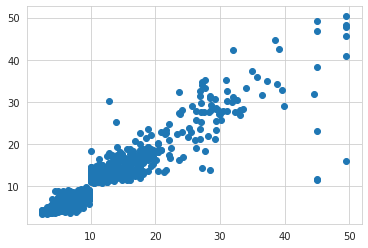

In [90]:
# 10 000 records
plt.scatter(testing_target.values,results)

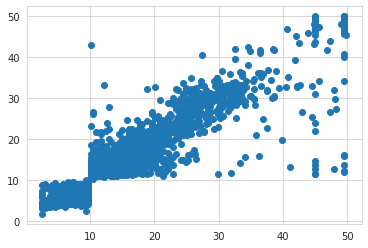

In [182]:
# 30 000 records
plt.scatter(testing_target.values,results)

In [183]:
from sklearn.metrics import mean_squared_error , mean_absolute_error 

print(f' Mean squared error {mean_squared_error(testing_target, results)}' )
print(f' Mean absolute error {mean_absolute_error(testing_target, results)}' )

# 1 generator

 #Mean squared error 8.200143655408343
 #Mean absolute error 1.4633068777304956


 # 5 generators

 #Mean squared error 5.9721446972614665
 #Mean absolute error 1.2685367023684182

 Mean squared error 5.9721446972614665
 Mean absolute error 1.2685367023684182


## Findings:
- Score with 10 000 records: 7.335333663634385 using TPOP REGRESSOR 
- Score with 30 000 MSE 5.9721446972614665
- XGBOOST was still working best
- The number of generations will affect the final result 
- I increased the number of records from 10 000 to 30 000 and saw a significant decrease on MSE

# 7. Final findings:
- Increasing the sample size improved the score by minimising the mean squared error 
- Numerical transformations such as PCA could reduce the mean squared error
- XGboost and Extra tree regressor methods for feature selection gave us similar results 
- Random Forest Regressor and XGBoost showed similar results with 5 fold cross validation with a smaller error using Random Forest 
- XGBOOST had a better performance than Random Forest after applying hyper parameter tuning
- Increasing the sample size and the number of genreators reduced the error 


 






# 8. Next steps:
- Opt Bayesian optimization